In [1]:
def sum_of_squares(v):
    """Computes the sum of squares"""
    return sum(v_i**2 for v_i in v)

This is the basis of the standard error function for evaluating the performance of predictive model. The sum of squares of the differences between the real y values and the predicted y values should be as small as possible.

In [38]:
import math
from functools import partial

def difference_quotient(f,x,h):
    """find the difference quotient. Returns approximate value of the derivative of f at x for small h"""
    return (f(x+h)-f(x))/h

def cosine_derivative(x):
    """returns the 'exact' value of the derivative of cosine at x"""
    return -math.sin(x)

#construct cosine derivative approximation function
approx_cosine_derivative = partial(difference_quotient, math.cos, h=0.0001)


acd = approx_cosine_derivative
cd = cosine_derivative

print acd(math.pi/2)
print cd(math.pi/2)




-0.999999998333
-1.0


In the next chart, we show that, even with $h$ quite large at $h=0.05$, the approximation to $cos'(x)$ is a pretty good one. Look a how the approximated points (red crosses) are close to the real values (blue plus).

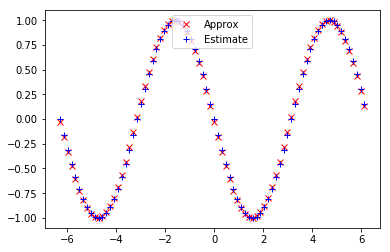

In [106]:
from matplotlib import pyplot as plt
import numpy as np

acd = partial(difference_quotient, math.cos, h=0.05)

xs = np.arange(-2,2,0.05)*math.pi 
approx_ys = [acd(x) for x in xs]
exact_ys = [cd(x) for x in xs]

fig, ax = plt.subplots(1)

ax.plot(xs, approx_ys, "rx", label="Approx")
ax.plot(xs, exact_ys, "b+", label="Estimate")
plt.legend(loc=9)
plt.show()

In [107]:
def partial_difference_quotient(f,v,i,h):
    """returns the approximation to the ith gradient component of the multivariate function f at the point v, for small h"""
    
    w = [v_j +(h if j==i else 0) for j, v_j in enumerate(v)]
    return (f(w)-f(v))/h

pdq = partial_difference_quotient
print pdq(lambda (x,y,z): x**2+y**3+z**4, (2,2,2), 2,0.0001)
#expect pdq(f,v,0,h) = 4, pdq(f,v,1,h) = 12, pdq(f,v,2,h)=32 for given values of f, v, h.


32.0024000801


In [225]:
import random

def distance(v,w):
    return math.sqrt(sum((v_i-w_i)**2 for v_i,w_i in zip(v,w)))

def step(v, direction, step_size):
    """move step_size in direction from v"""
    return [v_i +step_size*direction_i for v_i,direction_i in zip(v,direction)]

def sum_of_squares_gradient(v):
    return [2*v_i for v_i in v]

v = [random.randint(-10,10) for i in range(3)]

tolerance = 0.000001

def run_minimisation(v):
    """Minimises the sum of squares function"""
    while True:
        gradient = sum_of_squares_gradient(v) #compute the gradient at v
        next_v = step(v, gradient, -0.01)
        if distance(next_v, v) < tolerance:
            break
        v=next_v
    return v
# print run_minimisation(v)

def safe(f):
    """return a new function that's the same as f but outputs infty whenever f produces an error"""
    def safe_f(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except:
            return float('inf')
    return safe_f


In [257]:
def minimise_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    """Use gradient descent to find theta that minimises target function"""
    step_sizes = [1,0.1,0.01,0.001,0.0001,0.00001]
    
    theta = theta_0
    target_fn = safe(target_fn)
    gradient_fn = safe(gradient_fn)
    value = target_fn(theta)
    

    
    while True:
        gradient= gradient_fn(theta)
        next_thetas = [step(theta, gradient, -step_size) for step_size in step_sizes]
        next_theta = min(next_thetas, key=target_fn)
        next_value = target_fn(next_theta)
        
        if abs(value - next_value) < tolerance:
            return theta
        else:
            theta, value = next_theta, next_value
            
print minimise_batch(lambda  v: sum((v_i-1)**2 for v_i in v), lambda v: [2*v_i-2 for v_i in v], [1.5,-30,5,-1,5,7])

[1.000021778071483, 0.9986497595680577, 1.0001742245718634, 0.9999128877140683, 1.0001742245718634, 1.0002613368577953]


To check that I understood how this was working I ran this on a single variable quartic function and plotted the results

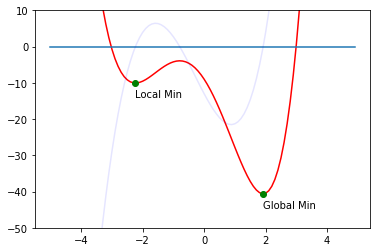

In [304]:
def quartic(x):
    """should take a vector of length 1"""
    x= x[0]
    return (x+3)*(x-3)*(x**2+2*x+1) + 5*math.sin(x)

def cubic(x):
    scalar_cubic = partial(partial_difference_quotient,quartic, i=0, h=0.00001 )
    return [scalar_cubic(x)]
    
xs = np.arange(-5,5,0.1)
ys = [quartic([x]) for x in xs]
ys2 = [0 for _ in xs]
ys3 = [cubic([x]) for x in xs]

x = minimise_batch(quartic, cubic, [-5]) #finds the shallow local min
x2 = minimise_batch(quartic, cubic, [1]) #finds the deeper global min
y = quartic(x)
y2 = quartic(x2)


fig, axs = plt.subplots(1)


axs.plot(xs,ys, "r-")
axs.plot(xs,ys2)
axs.plot(xs,ys3, "b-",alpha=0.1)
axs.plot(x,y,"go")
axs.plot(x2,y2,"go")
axs.annotate("Local Min",xy=(x[0],y-4))
axs.annotate("Global Min",xy=(x2[0],y2-4))
axs.set(ylim=[-50,10])


plt.show()






#works! 


In [1]:
def negate(f):
    """return a function that for any input x returns -f(x)"""
    return lambda *args, **kwargs: -f(*args, **kwargs)

def negate_all(f):
    """the same when f returns a list of numbers"""
    return lambda *args, **kwargs: [-y for y in f(*args, **kwargs)]

def maximise_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    return minimise_batch(negate(target_fn),negate_all(gradient_fn), theta_0, tolerance)





In [380]:
def in_random_order(data):
    """generator that returns data in some random order"""
    indexes = [i for i,_ in enumerate(data)]
    random.shuffle(indexes)
    for i in indexes:
        yield data[i]

def scalar_multiply(a,v):
    return [a*v_i for v_i in v]
        
def vector_subtract(v,w):
    return [v_i - w_i for v_i,w_i in zip(v,w)]
        
def minimise_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):
    """minimises target function one parameter at a time?"""
    data = zip(x,y)
    theta = theta_0                           #initial guess of input that yeilds minimum value
    alpha = alpha_0                           #initial step size
    min_theta, min_value = None, float("inf") #current minimum
    iterations_with_no_improvement = 0
    
    
    #if we ever go 100 iterations with no improvement, stop
    
    
    while iterations_with_no_improvement < 100:
        value = sum(target_fn(x_i, y_i, theta) for x_i, y_i in data)
        
        if value < min_value:
            min_theta, min_value = theta, value
            iterations_with_no_improvement = 0
            alpha = alpha_0
        else:
            #otherwise not improving, so try shrikning step size
            iterations_with_no_improvement += 1
            alpha *= 0.9
            
        for x_i, y_i in in_random_order(data):
            gradient_i = gradient_fn(x_i, y_i, theta)
            theta = vector_subtract(theta, scalar_multiply(alpha, gradient_i))
            
    return min_theta

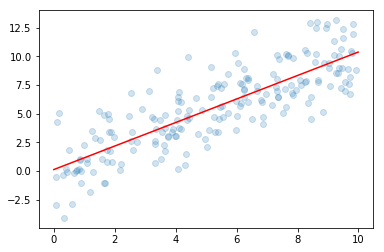

1.0248951195 0.134275332647


In [389]:
#generate a bunch of scattered points
np.random.seed(4)
xs = scalar_multiply(10,np.random.rand(200))
rands = np.random.normal(0,2,200)
ys = [x+r for x,r in zip(xs,rands)]

pts = zip(xs,ys)



def squared_error(x,y,params):
    """the squared y-distance from a line"""
    m,b = params #weird format so I cn plug directly into target_fn slot in SGD function
    return ((m*x+b)-y)**2

def sum_squares_error(data, params):
    """returns the sum of the squared errors of data on a given line"""
    m,b = params
    return sum(squared_error(x,y,m,b) for x,y in data)
    

#here target_fn is squares error, we want to minimise it to get the values of m and b, which define the regression line
#the gradient fn is the derivative of the target_fn (wrt what?). In the case of minimising a plain old function f(x,y)
#we would want to explore the values of x and y that make the output f(x,y) as small as possible. Here I think we only
#need to vary m and b. So, PD_m = sum(2x*(m*x+b - y) for x,y) and PD_b = sum(2*(m*x+b - y) for x,y). Another thing occurs to me
#if we're going to iterate though all the data points one by one, won't our gradient function change over time? Yep. Doesn't
#seem to matter, still worked. Could generalise this to a numerical gradient computation,
#where all mentions of the line mx+b and its parameters m,b are replaced by "model", to allow for different modelling functions

def se_grad(x,y,params):
    """The gradient of the squared_error as a function of m and b"""
    m,b = params
    return [2*x*(m*x+b-y),2*(m*x+b-y)]

def sse_grad(data, params):
    """The sum of the gradient of the squared_error function over a whole data set"""
    m,b = params
    return sum(se_grad(x,y,[m,b]) for x,y in data)

grad, intercept =  minimise_stochastic(squared_error, se_grad, xs, ys, [1,0])

fig, axs = plt.subplots(1)

lxs = np.arange(0,10,0.01)
lys = [grad*x +intercept for x in lxs]

axs.scatter(xs,ys,alpha=0.2)
axs.plot(lxs,lys, "r-")
plt.show()

print grad, intercept




You have a dataset and you want to develop a linear model that describes it. So you make a guess what the parameters $m$ and $b$ are. Call these $\theta$. You look at the size of the error (sum of squares of the deviation) and realise that maybe you guess wasn't very good. How can you improve your guess? One way is to apply calculus to minimise the error function. You have an explicit error function, so you can compute the gradient of the error function (by allowing the parameters to vary). You then take a step in parameter space in the -ive direction of the gradient. This should reduce the value of your error for the dataset, for a step of the right size.

Now, here is where you can make a choice about how to track the gradient. Your error function is the sum of the errors of the individual data points. You can choose to look at what each error and corresponding gradient component says individually, or as a whole. If you choose to hear what the datapoints have to say all together this is batch gradient descent. If you listen individually, this is stochastic gradient descent (stochastic because you're going to listen in a random order).

In [391]:
'''
======================
3D surface (color map)
======================

Demonstrates plotting a 3D surface colored with the coolwarm color map.
The surface is made opaque by using antialiased=False.

Also demonstrates using the LinearLocator and custom formatting for the
z axis tick labels.
'''

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

Should plot a nice volcano, but doesn't seem to be working.
